#### **Course Rating Prediction using Neural Networks**


##### **tf.keras.layers.Embedding**
- Turns positive integers (indexes) into dense vectors of fixed size.

**Resource** : https://www.kaggle.com/code/colinmorris/embedding-layers

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.layers import (
    Dense,
    Embedding,
    Flatten,
    Input,
    Dropout,
    Dot
)

from keras.models import Model

In [2]:
def load_ratings():
    return pd.read_csv('ratings.csv')

In [3]:
rating_df = load_ratings()
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


In [4]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


#### Implementing the recommender neural network using tensorflow


In [5]:
def emb_create(n_user, n_item, n_user_latent_dim: int = 16, n_item_latent_dim: int = 16, reg_users: int = 1e-6, reg_items: int = 1e-6) -> keras.Model:

    user_input = Input(shape=(), dtype='int32', name='user')
    item_input = Input(shape=(), dtype='int32', name='item')

    # USER
    user_embedding = Embedding(input_dim=n_user,
                    output_dim=n_user_latent_dim,
                    name='user_embedding',
                    embeddings_initializer="he_normal",
                    embeddings_regularizer=keras.regularizers.l2(reg_users)
                    )(user_input)
    
    user_vec = Flatten(name='user_flat')(user_embedding)

    user_bias = Embedding(input_dim=n_user,
                    output_dim=1,
                    name='user_bias',
                    embeddings_initializer="he_normal",
                    embeddings_regularizer=keras.regularizers.l2(reg_users)
                    )(user_input)
    
    user_model = Model(inputs=user_input, outputs=user_vec)

    # ITEM
    item_embedding = Embedding(input_dim=n_item,
                    output_dim=n_item_latent_dim,
                    name='item_embedding',
                    embeddings_initializer="he_normal",
                    embeddings_regularizer=keras.regularizers.l2(reg_items)
                    )(item_input)

    item_bias = Embedding(input_dim=n_user,
                    output_dim=1,
                    name='item_bias',
                    embeddings_initializer="he_normal",
                    embeddings_regularizer=keras.regularizers.l2(reg_users)
                    )(item_input)

    merged = Dot(name='dot', normalize=True, axes=1)([user_embedding, item_embedding])
    merged_dropout = Dropout(0.2)(merged)

    #hidden layers
    dense_1 = Dense(units=64, name='Dense_1')(merged_dropout)
    do_1 = Dropout(0.2, name='Dropout_1')(dense_1)

    dense_2 = Dense(units=32, name='Dense_2')(do_1)
    do_2 = Dropout(0.2, name='Dropout_2')(dense_2)

    dense_3 = Dense(units=16, name='Dense_3')(do_2)
    do_3 = Dropout(0.2, name='Dropout_3')(dense_3)

    dense_4 = Dense(units=8, name='Dense_4')(do_3)

    result = Dense(1, name='rating', activation='relu')(dense_4)

    model = Model(inputs=[user_input, item_input], outputs=[result])
    model._name = 'embedding_extraction_model'
    
    return model

The embedding matrix is updated using `gradient descent` + `backpropagation` just like any other layer in a neural network.

In [6]:
def emb_data_prep(raw_data):
    
    encoded_data = raw_data.copy()

    user_id2idx = {x: i for i, x in enumerate(encoded_data["user"].unique())}
    item_id2idx = {x: i for i, x in enumerate(encoded_data["item"].unique())}

    encoded_data['user'] = encoded_data['user'].map(user_id2idx)
    encoded_data['item'] = encoded_data['item'].map(item_id2idx)

    return encoded_data, user_id2idx, item_id2idx

In [7]:
encoded_data, user_id2idx, course_id2idx = emb_data_prep(rating_df)

In [8]:
def emb_ds_create(df, val_split = 0.1, batch_size = 512, rs = 42):
    
    if rs: 
        df = df.sample(frac=1, random_state=rs).reset_index(drop=True)

    n_val = round(len(df) * val_split)

    x = {
        'user': df['user'].values,
        'item': df['item'].values
    }
    y = df['rating'].values

    ds = tf.data.Dataset.from_tensor_slices((x, y))

    ds_val = ds.take(n_val).batch(batch_size)
    ds_train = ds.skip(n_val).batch(batch_size)
    
    return ds_train, ds_val

In [9]:
ds_train, ds_val = emb_ds_create(encoded_data)

In [10]:
def emb_train(ds_train, ds_val, epochs = 10, embedding_size = 16):

    df = load_ratings()
    num_users = len(df['user'].unique())
    num_items = len(df['item'].unique())

    emb_model = emb_create(n_user=num_users, n_item=num_items, n_item_latent_dim=embedding_size, n_user_latent_dim=embedding_size)
    emb_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=[tf.keras.metrics.MeanSquaredError()])
    emb_model_hist = emb_model.fit(x = ds_train, validation_data = ds_val, epochs=epochs, verbose=1)

    return emb_model, emb_model_hist

In [11]:
emb, emb_hist = emb_train(ds_train=ds_train, ds_val=ds_val)

Epoch 1/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 2.1128 - mean_squared_error: 2.1127 - val_loss: 0.0469 - val_mean_squared_error: 0.0468
Epoch 2/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.2071 - mean_squared_error: 0.2070 - val_loss: 0.0465 - val_mean_squared_error: 0.0463
Epoch 3/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1372 - mean_squared_error: 0.1370 - val_loss: 0.0445 - val_mean_squared_error: 0.0444
Epoch 4/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0823 - mean_squared_error: 0.0821 - val_loss: 0.0438 - val_mean_squared_error: 0.0436
Epoch 5/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0560 - mean_squared_error: 0.0558 - val_loss: 0.0437 - val_mean_squared_error: 0.0435
Epoch 6/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0480 - mean_squared_error: 0.0479 - val_loss: 0.0437 - val_mean_squared_error: 0.0435
Epoch 7/10
411/411 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0463 - mean_squared_error: 0.0461 - val_lo

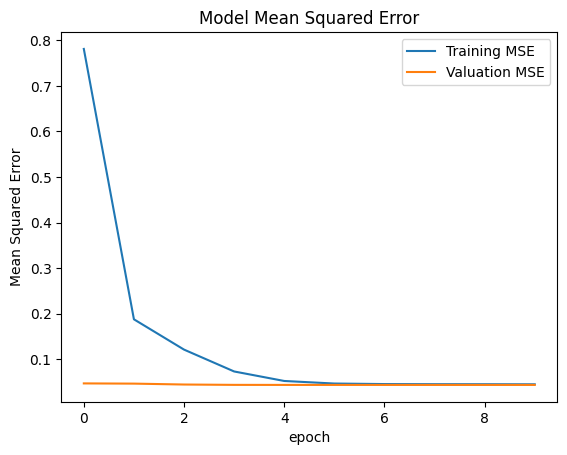

In [12]:
from matplotlib import pyplot as plt

plt.plot(emb_hist.history['mean_squared_error'])
plt.plot(emb_hist.history['val_mean_squared_error'])
plt.title('Model Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('epoch')
plt.legend(['Training MSE', 'Valuation MSE'], loc='upper right')
plt.show()

In [13]:
user_latent_features = emb.get_layer('user_embedding').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

item_latent_features = emb.get_layer('item_embedding').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

User features shape: (33901, 16)
Item features shape: (126, 16)


In [14]:
user_latent_df = pd.DataFrame(user_latent_features, columns=[f'User_Feature_{i}' for i in range(user_latent_features.shape[1])])
user_latent_df.insert(0, 'User_ID', list(user_id2idx.keys()))
user_latent_df.head()

,User_ID,User_Feature_0,User_Feature_1,User_Feature_2,User_Feature_3,User_Feature_4,User_Feature_5,User_Feature_6,User_Feature_7,User_Feature_8,User_Feature_9,User_Feature_10,User_Feature_11,User_Feature_12,User_Feature_13,User_Feature_14,User_Feature_15
0,1889878,-0.016606,-0.016089,-0.003369,-0.035137,0.000975,0.017438,-0.010913,0.007628,0.016686,0.004802,0.005720,-0.011686,-0.005172,0.009153,-0.015774,0.004194
1,1342067,-0.034844,-0.002126,-0.017890,-0.028600,-0.011657,0.004055,0.002278,0.004140,0.009584,0.016630,0.012418,0.020363,-0.016852,-0.037288,0.017049,-0.004547
2,1990814,-0.002432,-0.021900,-0.018091,0.012186,-0.001424,-0.015392,0.008118,-0.016446,-0.001566,0.002180,0.017815,-0.012579,0.007957,-0.013742,0.026470,-0.001333
3,380098,-0.000387,-0.018908,0.000263,0.009960,0.024397,0.003105,-0.005399,0.010141,0.012209,-0.004895,-0.014266,-0.009943,0.010241,0.019553,0.013327,-0.002911
4,779563,0.013837,0.002045,-0.005562,0.003339,-0.019105,-0.000067,0.012716,-0.001674,0.000287,-0.016167,0.024513,-0.000466,-0.000027,-0.012555,0.005529,-0.017677


In [15]:
course_latent_df = pd.DataFrame(item_latent_features, columns= [f'Course_Feature_{i}' for i in range(item_latent_features.shape[1])])
course_latent_df.insert(0, 'Course_ID', list(course_id2idx.keys()))
course_latent_df.head()

,Course_ID,Course_Feature_0,Course_Feature_1,Course_Feature_2,Course_Feature_3,Course_Feature_4,Course_Feature_5,Course_Feature_6,Course_Feature_7,Course_Feature_8,Course_Feature_9,Course_Feature_10,Course_Feature_11,Course_Feature_12,Course_Feature_13,Course_Feature_14,Course_Feature_15
0,CC0101EN,-0.039493,-0.046961,-0.031280,-0.015159,-0.257075,0.007762,-0.120023,0.118434,0.094517,0.279441,-0.110488,0.054886,-0.029876,-0.071809,-0.010483,0.079570
1,CL0101EN,-0.072549,0.056140,0.294247,-0.090112,-0.081289,0.243462,0.267263,-0.025282,0.033823,0.194806,-0.017052,0.044629,-0.251677,-0.140366,0.158388,0.120748
2,ML0120ENv3,-0.017471,0.044615,-0.099044,-0.011788,0.039947,0.176448,-0.034120,0.071214,-0.063434,-0.107145,-0.065945,-0.045263,0.020473,-0.097950,0.076773,0.057337
3,BD0211EN,0.233830,-0.080934,-0.058808,-0.084407,0.118824,-0.182455,0.193202,-0.043035,0.250306,-0.011129,0.025923,-0.289598,0.107959,0.287435,0.065177,-0.055921
4,DS0101EN,0.221674,-0.012474,0.278967,0.040157,0.084193,-0.012153,0.123990,0.173688,0.142995,-0.113967,0.079826,0.059155,-0.090087,0.125606,-0.014606,-0.088862


In [16]:
user_latent_df.to_csv('User_Embeddings.csv', index=False)

In [17]:
course_latent_df.to_csv('Course_Embeddings.csv', index=False)